In [11]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import random
import shutil

In [12]:
def run_prediction(model, to_annotate_folder):
    # Menggunakan model untuk melakukan prediksi
    auto_annotation = model.predict(source=to_annotate_folder, save=True)

    # Inisialisasi penghitung untuk setiap kategori
    counts = {
        "less_than_30": 0,
        "equal_30": 0,
        "equal_31": 0,
        "equal_32": 0,
        "greater_than_32": 0,
    }

    # Hitung jumlah bounding box untuk setiap gambar
    for result in auto_annotation:
        num_boxes = len(result.boxes.xyxy)  # Menghitung jumlah bounding box

        if num_boxes < 30:
            counts["less_than_30"] += 1
        elif num_boxes == 30:
            counts["equal_30"] += 1
        elif num_boxes == 31:
            counts["equal_31"] += 1
        elif num_boxes == 32:
            counts["equal_32"] += 1
        elif num_boxes > 32:
            counts["greater_than_32"] += 1

    # Menampilkan hasil penghitungan
    print("Ringkasan Jumlah Bounding Box:")
    for key, value in counts.items():
        print(
            f"Jumlah gambar dengan bounding box {key.replace('_', ' ').capitalize()}: {value}"
        )

    return auto_annotation

In [13]:
def manual_quality_control(auto_annotation_sample):
    for result in auto_annotation_sample:
        img_path = result.path
        original_image = cv2.imread(img_path)

        if result.boxes and len(result.boxes.xyxy) > 0:
            print(f"Detected boxes in {img_path}: {len(result.boxes.xyxy)}")

            for box in result.boxes.xyxy:
                if len(box) == 4:
                    x1, y1, x2, y2 = box
                    conf = None
                    cls = None
                elif len(box) == 6:
                    x1, y1, x2, y2, conf, cls = box

                label = f'Class: {int(cls)}, Conf: {conf:.2f}' if conf is not None and cls is not None else ''
                cv2.rectangle(original_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                if label:
                    cv2.putText(original_image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            print(f"No boxes detected in {img_path}")

        # Tampilkan gambar
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Predictions for {os.path.basename(img_path)}")
        plt.show()

In [16]:
def save_prediction_results(auto_annotation_sample, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Membuat folder jika belum ada

    for result in auto_annotation_sample:
        img_path = result.path
        original_image = cv2.imread(img_path)

        # Menyimpan gambar asli tanpa bounding box
        original_image_output = os.path.join(output_folder, f'original_{os.path.basename(img_path)}')
        cv2.imwrite(original_image_output, original_image)

        # Menyiapkan file untuk menyimpan bounding box
        bbox_output_filename = os.path.join(output_folder, f'bboxes_{os.path.splitext(os.path.basename(img_path))[0]}.txt')

        with open(bbox_output_filename, 'w') as bbox_file:
            if result.boxes and len(result.boxes.xyxy) > 0:
                for box in result.boxes.xyxy:
                    if len(box) == 4:
                        x1, y1, x2, y2 = box
                        conf = None
                        cls = None
                    elif len(box) == 6:
                        x1, y1, x2, y2, conf, cls = box

                    # Simpan informasi bounding box ke dalam file
                    if cls is not None and conf is not None:
                        bbox_file.write(f"{int(cls)} {x1} {y1} {x2} {y2} {conf:.4f}\n")
                    else:
                        # Jika tidak ada kelas atau confidence, kita bisa menyimpan informasi default
                        bbox_file.write(f"Unknown {x1} {y1} {x2} {y2}\n")

                    # Gambar bounding box pada gambar
                    cv2.rectangle(original_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    if conf is not None and cls is not None:
                        label = f'Class: {int(cls)}, Conf: {conf:.2f}'
                        cv2.putText(original_image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Simpan gambar yang telah dihias dengan bounding box
                annotated_image_output = os.path.join(output_folder, f'annotated_{os.path.basename(img_path)}')
                cv2.imwrite(annotated_image_output, original_image)
            else:
                bbox_file.write("No boxes detected\n")  # Catatan jika tidak ada kotak yang terdeteksi

In [14]:
model = YOLO("../models/yolo8s-100.pt")
to_annotate_folder = "../data/images"
auto_annotation_sample = run_prediction(model, to_annotate_folder)


image 1/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-174.jpg: 352x640 31 class_names, 82.2ms
image 2/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-176.jpg: 352x640 31 class_names, 78.6ms
image 3/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-177.jpg: 352x640 31 class_names, 82.0ms
image 4/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-178.jpg: 352x640 33 class_names, 91.3ms
image 5/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-180.jpg: 352x640 32 class_names, 80.8ms
Speed: 1.9ms preprocess, 83.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)
Results saved to d:\Code\ktp-text-recog\runs\detect\predict3
Ringkasan Jumlah Bounding Box:
Jumlah gambar dengan bounding box Less than 30: 0
Jumlah gambar dengan bounding box Equal 30: 0
Jumlah gambar dengan bounding box Equal 31: 3
Jumlah gambar dengan bounding box Equal 32: 1
Jumlah gambar dengan bounding box Greater than 32: 1


Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-174.jpg: 31


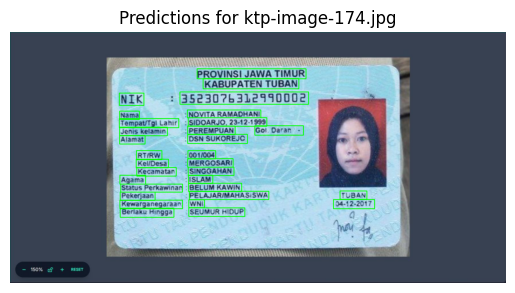

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-176.jpg: 31


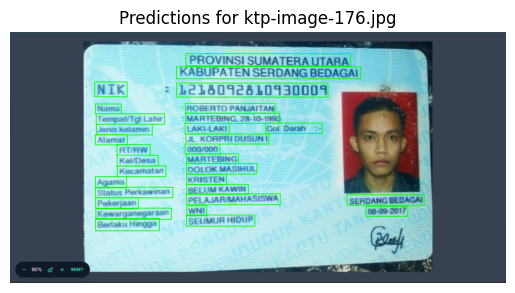

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-177.jpg: 31


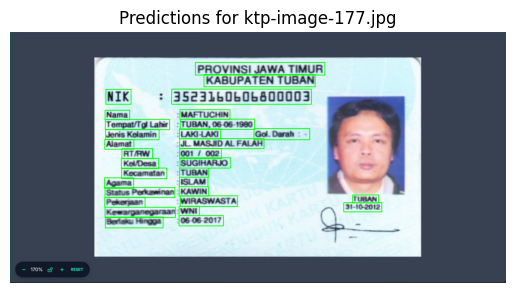

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-178.jpg: 33


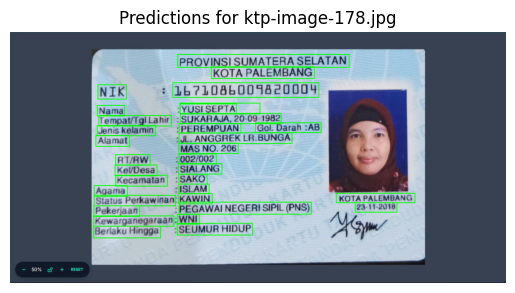

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-180.jpg: 32


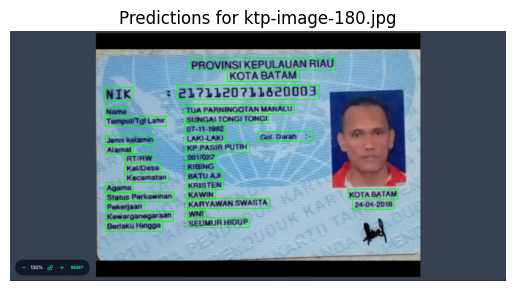

In [15]:
manual_quality_control(auto_annotation_sample)

In [18]:
output_annotation = "../data/auto-annotations/"
save_prediction_results(auto_annotation_sample, output_annotation)